<a href="https://colab.research.google.com/github/maashha/Nonogram-solver/blob/main/Nonogram_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
pip install --upgrade pip

In [27]:
pip install pycosat

In [28]:
import pycosat

In [29]:
import os

In [30]:
import time

In [31]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [32]:
def existence(series, length, sizes, number):
    final = []
    maximum = 0
    minimum = -1
    non_empty = []
    uniqueness = []
    for group in range(len(series)):
        starting_positions = []
        if group!=0:
            #move borders on the length of the previous block
            left += series[group-1] + 1
            right += series[group-1] + 1
        else:
            left = 0
            right = length + 1 - sum(series[0:]) - len(series)
        for possible in range(left, right+1):
            position = (possible+1)+sizes+length*(number+group)
            starting_positions.append(position) #add all possible positions of the first cell of the block to one array
            non_empty.append(position)
            if maximum<position:
                maximum = position
            if minimum > position or minimum == -1:
                minimum = position
            for can in range(possible+1, right+1):
                uniqueness.append([-position, -((can+1)+sizes+length*(number+group))]) #exclude situations where one block has two starting cells
        final.append(starting_positions) #all of such starting_positions for one row or column
    return [final, uniqueness, maximum, minimum, non_empty]

In [33]:
def intersection(sets, lengths, amount):
    intersect = []
    for section_1 in range(len(sets)):
        for section_2 in range(section_1+1, len(sets)): #choose two sets of starting positions of the blocks
            for first in range(len(sets[section_1])):
                for second in range(len(sets[section_2])): #add elements of the first array in pairs with elements of the second, excluding their intersection
                    if abs((sets[section_1][first]) - (sets[section_2][second])) % amount < sum(lengths[section_1:section_2]) + (section_2-section_1) and abs((sets[section_1][first]) - (sets[section_2][second]))>=amount:
                        intersect.append([-(sets[section_1][first]), -(sets[section_2][second])])
                        if first>=3:
                            intersect.append([-(sets[section_1][first]), -(sets[section_2][first-3])])
    return intersect

In [34]:
def cell_rows(mx, size, lenn, start, mn, something, liine,pr):
    all_cells = []
    no = []
    empty = []
    se = []
    y = {}
    for i in range(start+1, start+lenn+1):
        cells = [-i]
        if i%lenn!=0:
            for j in range(mn+i%lenn-1, mx+1, lenn):
                if j not in no and j not in something:
                    no.append([-j])
                else:
                    cells.append(j)
                    for n in range(i, i+liine[(j-pr)//lenn]):
                        se.append([-j,n])
                        if n in y.keys():
                            y[n].append(j)
                        else:
                            y[n] = [-n,j]
                    empty.append([i,-j])
        else:
            for j in range(mn+lenn-1, mx+1, lenn):
                if j not in no and j not in something:
                    no.append([-j])
                else:
                    cells.append(j)
                    for n in range(i, i+liine[(j-pr)//lenn-1]):
                        se.append([-j,n])
                        if n in y.keys():
                            y[n].append(j)
                        else:
                            y[n] = [-n,j]
                    empty.append([i,-j])
        all_cells.append(cells)
        all_cells = []
    return [se, empty, no,y]

In [35]:
def cell_columns(mx, size, lenn, start, mn, something, amoun, nuum, liine,pr):
    all_cells = []
    no = []
    empty = []
    se = []
    yw = {}
    for i in range(start+1, start+lenn+1):
        yw[((i-1)%lenn)*amoun+(i-1)//lenn+1] = [-(((i-1)%lenn)*amoun+(i-1)//lenn+1)]
    for i in range(start+1, start+lenn+1):
        cells = [-(((i-1)%lenn)*amoun+(i-1)//lenn+1)]
        if i%lenn!=0:
            for j in range(mn+i%lenn-1, mx+1, lenn):
                if j not in no and j not in something:
                    no.append([-j])
                else:
                    cells.append(j)
                    for n in range(i, i+liine[(j-pr)//lenn]):
                        se.append([-j,((n-1)%lenn)*amoun+(n-1)//lenn+1])
                        yw[((n-1)%lenn)*amoun+(n-1)//lenn+1].append(j)
                    empty.append([((i-1)%lenn)*amoun+(i-1)//lenn+1,-j])
        else:
            for j in range(mn+lenn-1, mx+1, lenn):
                if j not in no and j not in something:
                    no.append([-j])
                else:
                    cells.append(j)
                    for n in range(i, i+liine[(j-pr)//lenn-1]):
                        se.append([-j,((n-1)%lenn)*amoun+(n-1)//lenn+1])
                        yw[((n-1)%lenn)*amoun+(n-1)//lenn+1].append(j)
                    empty.append([((i-1)%lenn)*amoun+(i-1)//lenn+1,-j])
        all_cells.append(cells)
    return [se, empty, no, yw]

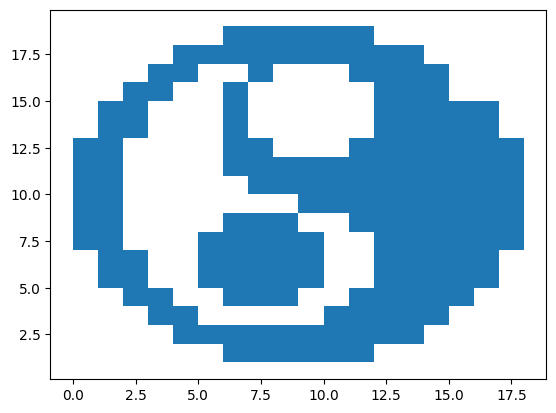

In [42]:
class Nonogram:
  def load_from_file(self,file_name):
    line_number = 0
    self.rows = 0
    self.columns = 0
    self.all_rows = [] #the array of all blocks of filled cells in ROWS
    self.all_columns = [] #the array of all blocks of filled cells in COLUMNS
    if os.path.isfile(file_name):
      with open(file_name, "r") as file:
        for line in file:
          line_number += 1
          if line_number == 1:
            self.rows = int(line.split(" ")[0])
            self.columns = int(line.split(" ")[1])
          elif line_number <= 1 + self.rows:
              self.all_rows.append(list(map(int, line.split())))
          else:
              self.all_columns.append(list(map(int, line.split())))
  def solve(self):
    solutions = []
    previous = 0
    lennn = []
    max_num = self.rows*self.columns
    everything = []
    for i in range(self.rows):
        blocks = self.all_rows[i] #all filled in cells in the ith row
        if max_num%self.columns==0:
            ma = max_num
        else:
            ma = max_num + (self.columns-max_num%self.columns)
        if blocks==[0]: #case of the empty row
            for empty in range(i*self.columns+1, (i+1)*self.columns+1):
                solutions.append([-empty])
            continue
        all_starts = existence(blocks, self.columns, self.rows*self.columns, previous)
        exist  = all_starts[0] #array of all possible starting possitions of the blocks
        unique_start  = all_starts[1] #exclusion of two starts at the same time
        max_num = all_starts[2]
        min_num = all_starts[3]
        color = all_starts[4]
        for j in exist:
            solutions.append(j)
        for j in unique_start:
            solutions.append(j)
        for j in intersection(exist, blocks, self.columns):
            solutions.append(j)
        get = cell_rows(max_num, self.columns*self.rows, self.columns, i*self.columns, min_num, color, blocks,ma)
        colored = get[0]
        emptys = get[1]
        nothing  = get[2]
        d = get[3]
        for j in emptys:
            solutions.append(j)
        for j in colored:
            solutions.append(j)
        for j in nothing:
            solutions.append(j)
        for j in d:
            solutions.append(d[j])
        previous += len(blocks)
    previous = 0
    for column in range(self.columns):
        blocks = self.all_columns[column]
        got = existence(blocks, self.rows, self.rows*self.columns, previous)
        if column==0:
            if max_num%self.columns==0:
                mm = max_num
            else:
                mm = max_num + (self.columns-max_num%self.columns)
            att = mm-self.columns*self.rows
        if (max_num-att)%self.rows==0:
                mm = max_num
        else:
            mm = max_num + (self.rows-(max_num-att)%self.rows)
        if blocks==[0]:
            for h in range(column*self.rows+1, column*self.rows+self.rows+1):
                solutions.append([-(((h-1)%self.rows)*self.columns+(h-1)//self.rows+1)])
            continue
        sol_1 = []
        sol_2 = []
        solution_1  = got[0]
        solution_2  = got[1]
        for i in solution_1:
            solution_1_1 = []
            for j in i:
                solution_1_1.append(j+att)
            sol_1.append(solution_1_1)
        for i in solution_2:
            solution_2_1 = []
            for j in i:
                solution_2_1.append(-(j*(-1)+att))
            sol_2.append(solution_2_1)
        solution_1  = sol_1.copy()
        solution_2  = sol_2.copy()
        max_num = got[2]+att
        min_num = got[3]+att
        color = got[4]
        colll = []
        for i in color:
            colll.append(i+att)
        color = colll.copy()
        for j in solution_1:
            solutions.append(j)
        for j in solution_2:
            solutions.append(j)
        for j in intersection(solution_1, blocks, self.rows):
            solutions.append(j)
        get = cell_columns(max_num, self.columns*self.rows, self.rows, column*self.rows, min_num, color, self.columns,column, blocks, mm)
        colored = get[0]
        emptys = get[1]
        nothing  = get[2]
        nj = get[3]
        for j in emptys:
            solutions.append(j)
        for j in colored:
            solutions.append(j)
        for j in nothing:
            solutions.append(j)
        for j in nj:
            solutions.append(nj[j])
        previous += len(blocks)
    self.solved = pycosat.solve(solutions)
  def draw(self):
    fig, ax = plt.subplots()
    ax.plot()
    if self.solved!='UNSAT':
      for i in range(self.rows*self.columns):
        if i%self.columns==(self.columns-1):
          if self.solved[i]>=0:
            ax.add_patch(Rectangle((i%self.columns,self.rows-i//self.columns), 1, 1))
        else:
          if self.solved[i]>=0:
            ax.add_patch(Rectangle((i%self.columns,self.rows-i//self.columns), 1, 1))
    plt.show()
my_object = Nonogram()
my_object.load_from_file('test3.txt')
my_object.solve()
my_object.draw()